In [1]:
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path
import h5py
from tqdm import tqdm
from itertools import product
import multiprocessing as mp

In [3]:
import matplotlib.pyplot as plt

In [4]:
from robust_motifs.data import (save_count_graph_from_matrix, matrix_shuffle,
                                import_connectivity_matrix, adjust_bidirectional_edges,
                               load_sparse_matrix_from_pkl)
from robust_motifs.custom_mp import prepare_shared_memory
from robust_motifs.counting import get_n_extended_simplices

In [5]:
original_matrix = import_connectivity_matrix(dataframe = False, type = 'csr')

pathway_shuffled_matrix = import_connectivity_matrix(dataframe= False, type='csr', pathway_shuffle=True)

shuffled_matrix = matrix_shuffle(original_matrix, exclude_diagonal=True)

100%|██████████| 55/55 [00:36<00:00,  1.52it/s]


In [6]:
original_matrix.multiply(original_matrix.T)

<31346x31346 sparse matrix of type '<class 'numpy.bool_'>'
	with 182932 stored elements in Compressed Sparse Row format>

In [7]:
bid_adjusted_matrix = adjust_bidirectional_edges(shuffled_matrix, int(182932/2))

Adding bidirectional edges...: 100%|██████████| 61506/61506 [00:00<00:00, 149983.99it/s]


In [8]:
bid_adjusted_matrix.multiply(bid_adjusted_matrix.T)

<31346x31346 sparse matrix of type '<class 'numpy.bool_'>'
	with 182932 stored elements in Compressed Sparse Row format>

In [9]:
shuffled_matrix

<31346x31346 sparse matrix of type '<class 'numpy.bool_'>'
	with 7648079 stored elements in Compressed Sparse Row format>

### Processing

In [10]:
overall_results = [{}, {}, {}, {}]

### Column

In [11]:
save_path = Path("data/models/column/column.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, original_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 3142695.19it/s]
7648079it [00:11, 669727.13it/s]


In [12]:
pool = mp.Pool()

In [13]:

complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_n_extended_simplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, 0) + elem[0]
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = 0
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        
        overall_results[0][dimension] = overall_results[0].get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 81766, 2: 100512, 3: 112298, 4: 122829, 5: 131986, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 84241, 2: 100015, 3: 113772, 4: 121209, 5: 132609, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 83164, 2: 99875, 3: 112839, 4: 122311, 5: 129598, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 82369, 2: 100128, 3: 113449, 4: 122634, 5: 130318, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 83408, 2: 100967, 3: 111984, 4: 121265, 5: 130078, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 83785, 2: 99970, 3: 111753, 4: 120651, 5: 129947, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 82960, 2: 98687, 3: 112787, 4: 122340, 5: 130922, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 82359, 2: 99490, 3: 112945, 4: 121797, 5: 129857, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 83788, 2: 99823, 3: 111520, 4: 121752, 5: 131077, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


100%|██████████| 6/6 [01:33<00:00, 15.60s/it]

Extended simplices for 10000 simplices per dimension
{1: 82535, 2: 99195, 3: 113337, 4: 123307, 5: 131540, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


<BarContainer object of 6 artists>

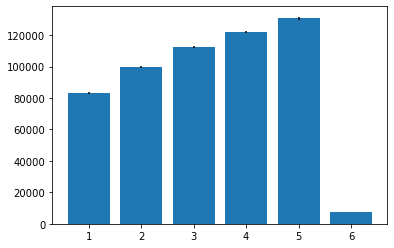

In [14]:
a = []
b = []
for elem in overall_results[0].values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)

### Pathway shuffled

In [15]:
save_path = Path("data/models/pshuffled/pshuffled.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, pathway_shuffled_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 3106899.19it/s]
7648079it [00:11, 643430.63it/s]


In [16]:
pool = mp.Pool()

In [17]:
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_n_extended_simplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, 0) + elem[0]
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = 0
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        
        overall_results[1][dimension] = overall_results[1].get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 32093, 2: 37215, 3: 40422, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 32111, 2: 37080, 3: 40758, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 32354, 2: 36969, 3: 40632, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 32749, 2: 36991, 3: 40495, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 31916, 2: 36993, 3: 40665, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 32418, 2: 37014, 3: 40785, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 32115, 2: 37370, 3: 40539, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 32341, 2: 37198, 3: 40591, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 32287, 2: 36984, 3: 40369, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


100%|██████████| 6/6 [00:51<00:00,  8.59s/it]

Extended simplices for 10000 simplices per dimension
{1: 32167, 2: 37132, 3: 40469, 4: 7835, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 24802713, 3: 1422883, 4: 1795, 5: 0, 6: 0}


<BarContainer object of 6 artists>

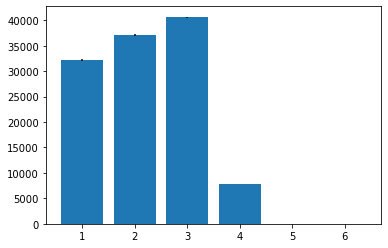

In [18]:
a = []
b = []
for elem in overall_results[1].values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)

### ER

In [19]:
save_path = Path("data/models/shuffled/shuffled.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, shuffled_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 2997529.77it/s]
7648079it [00:11, 667398.62it/s]


In [20]:
pool = mp.Pool()

In [21]:
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_n_extended_simplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, 0) + elem[0]
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = 0
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        
        overall_results[2][dimension] = overall_results[2].get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19187, 2: 18975, 3: 19220, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19394, 2: 19097, 3: 19128, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 18874, 2: 19159, 3: 19049, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19073, 2: 18973, 3: 19049, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19085, 2: 19337, 3: 18954, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 18958, 2: 18987, 3: 19278, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 18912, 2: 19181, 3: 19015, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 18931, 2: 18920, 3: 19282, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19272, 2: 19058, 3: 19026, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


100%|██████████| 6/6 [00:47<00:00,  7.97s/it]

Extended simplices for 10000 simplices per dimension
{1: 19309, 2: 19061, 3: 18941, 4: 20, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523046, 3: 214313, 4: 19, 5: 0, 6: 0}


<BarContainer object of 6 artists>

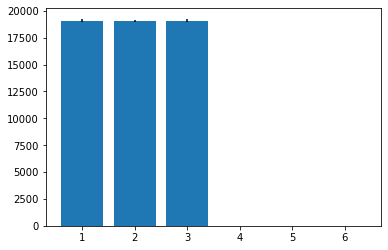

In [22]:
a = []
b = []
for elem in overall_results[2].values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)

### ER bid adjusted

In [23]:
save_path = Path("data/models/adjusted/adjusted.flag")
save_path.parent.mkdir(exist_ok=True, parents=True)
flag_path, pkl_path, count_path =save_count_graph_from_matrix(save_path, bid_adjusted_matrix)

100%|██████████| 31346/31346 [00:00<00:00, 2989555.08it/s]
7648079it [00:11, 669043.46it/s]


In [24]:
pool = mp.Pool()

In [25]:
complex_file = h5py.File(count_path, 'r')
matrix = load_sparse_matrix_from_pkl(pkl_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_n_extended_simplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, 0) + elem[0]
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = 0
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        
        overall_results[3][dimension] = overall_results[3].get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 58576, 2: 58099, 3: 58682, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 58197, 2: 58014, 3: 58553, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 58189, 2: 58103, 3: 58621, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 58591, 2: 58167, 3: 58558, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 58133, 2: 58450, 3: 58594, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 58994, 2: 58607, 3: 58524, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 58589, 2: 58093, 3: 58408, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 58220, 2: 57912, 3: 58469, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 58151, 2: 58645, 3: 58386, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


100%|██████████| 6/6 [00:50<00:00,  8.38s/it]

Extended simplices for 10000 simplices per dimension
{1: 58122, 2: 58294, 3: 58212, 4: 102, 5: 0, 6: 0}
Total simplices per dimension
{1: 7648079, 2: 14523010, 3: 214365, 4: 21, 5: 0, 6: 0}


<BarContainer object of 6 artists>

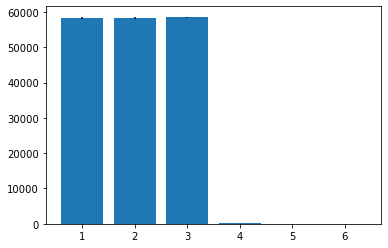

In [26]:
a = []
b = []
for elem in overall_results[3].values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)

Text(0, 0.5, 'Extended simplices / simplex')

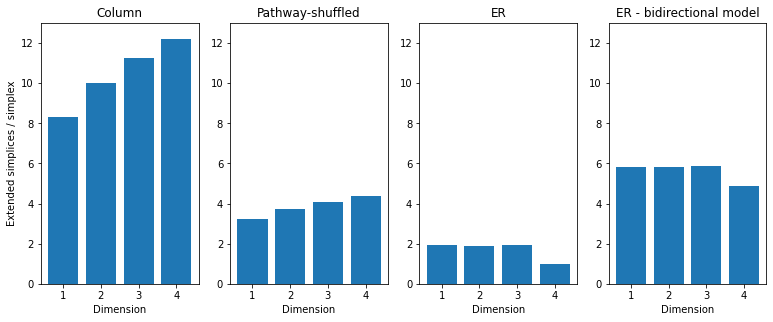

In [29]:
img, axes = plt.subplots(1,4,figsize = [13, 4.8])
titles = ["Column", "Pathway-shuffled", "ER", "ER - bidirectional model"]
s_d4 = [6599529, 1795, 20, 21]
for ax, dicts, title, s in zip(axes, overall_results, titles, s_d4):
    a = []
    for elem in dicts.values():
        a.append(np.mean(elem)/10000)
    a[3] = a[3]*10000/min(10000, s)
    ax.bar(range(1,5), a[:4])
    ax.set_xlabel("Dimension")
    ax.set_ylim(0,13)
    ax.set_title(title)
axes[0].set_ylabel("Extended simplices / simplex")


In [30]:
img.savefig(fname = "Comparison extended simplices", transparent=False, facecolor = "white")
      